In [2]:
import pypsa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import numpy as np

# Load network
network_file="/Users/antoniagrindrod/Documents/pypsa-earth_project/pypsa-earth-RL/networks/elec_s_50_ec_lc1.0_1h.nc"
n = pypsa.Network(network_file)


INFO:pypsa.io:Imported network elec_s_50_ec_lc1.0_1h.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units


/Users/antoniagrindrod/miniconda3/envs/pypsa-earth-rl/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/antoniagrindrod/miniconda3/envs/pypsa-earth-rl/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/Users/antoniagrindrod/miniconda3/envs/pypsa-earth-rl/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/Users/antoniagrindrod/miniconda3/envs/pypsa-earth-rl/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)

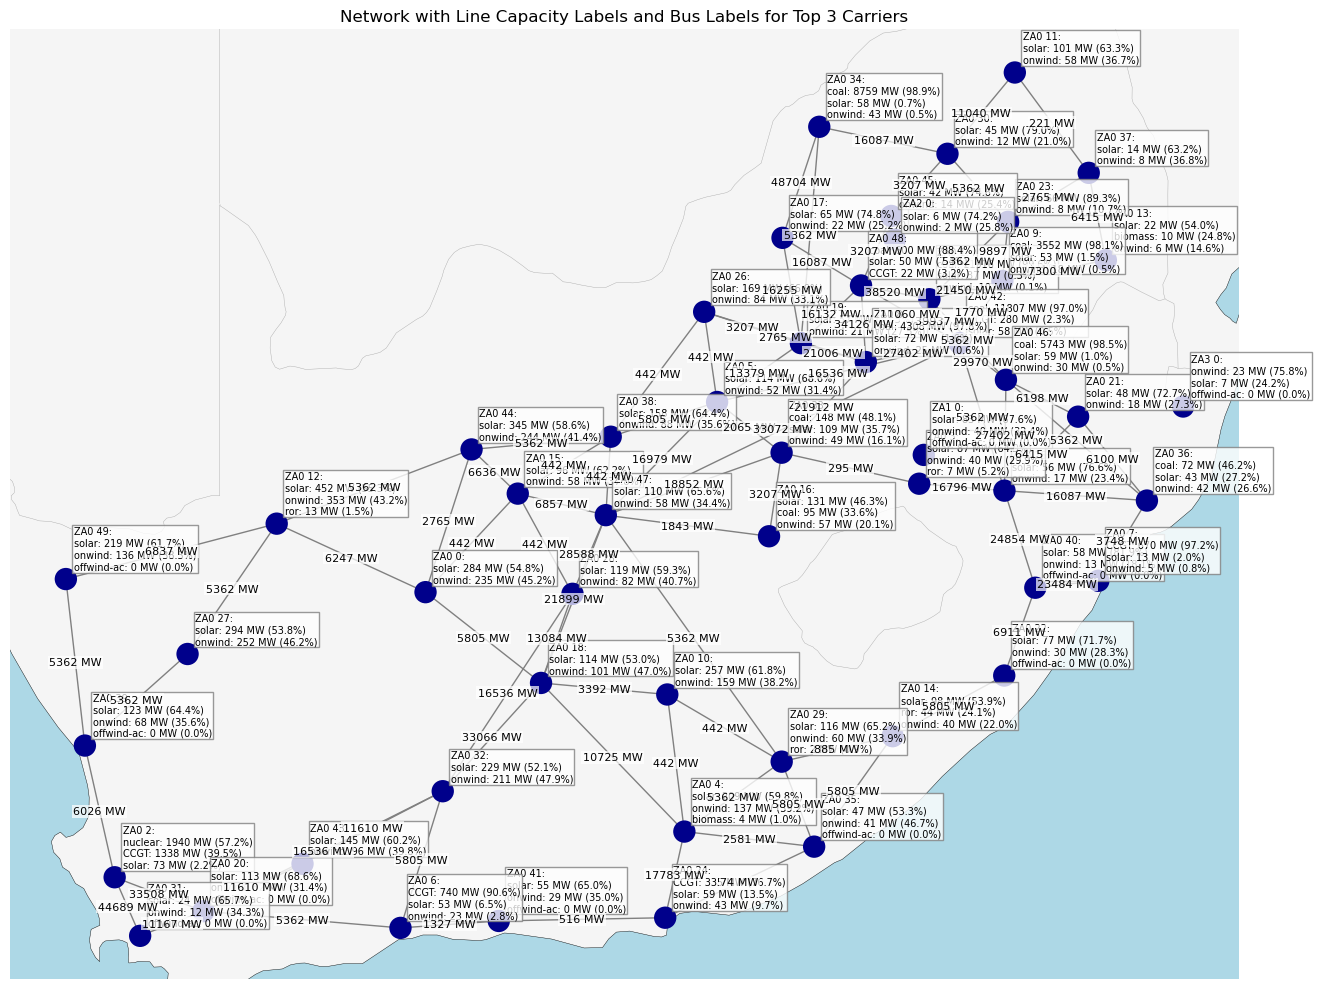

In [3]:
# Customizable function for bus labels with top carriers
def plot_network_with_bus_labels(network, num_top_carriers=3, figsize=(14, 10), 
                               show_percentages=True, label_offset=(0.1, 0.1)):
    """
    Plot network with uniform bus sizes and labels showing top carriers.
    
    Parameters:
    -----------
    network : pypsa.Network
        The PyPSA network to plot
    num_top_carriers : int, optional
        Number of top carriers to show for each bus (default: 3)
    figsize : tuple, optional
        Figure size (default: (14, 10))
    show_percentages : bool, optional
        Whether to show percentages in labels (default: True)
    label_offset : tuple, optional
        (x, y) offset for label positioning (default: (0.1, 0.1))
    """
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    
    fig, ax = plt.subplots(figsize=figsize, subplot_kw={"projection": ccrs.PlateCarree()})
    
    # Plot network with uniform bus sizes
    network.plot(
        ax=ax,
        bus_sizes=0.02,  # Uniform size for all buses
        bus_colors='darkblue',  # Uniform color for all buses
        line_widths=1.0,  # Uniform line width
        line_colors='gray',
        title=f"Network with Line Capacity Labels and Bus Labels for Top {num_top_carriers} Carriers",
        color_geomap=True,
        geomap=True,
    )
    
    # Calculate generation stats by bus and carrier
    if not network.generators.empty:
        # Group generators by bus and carrier, and sum their capacities
        bus_carrier_stats = network.generators.groupby(['bus', 'carrier'])['p_nom'].sum().reset_index()
        
        # Calculate total capacity per bus for percentage calculation
        bus_total_capacity = bus_carrier_stats.groupby('bus')['p_nom'].sum()
        
        # Get top carriers for each bus
        bus_stats = {}
        for bus in network.buses.index:
            # Get generators at this bus
            bus_data = bus_carrier_stats[bus_carrier_stats.bus == bus]
            if not bus_data.empty:
                # Sort by capacity (descending) and take top N
                top_carriers = bus_data.sort_values('p_nom', ascending=False).head(num_top_carriers)
                bus_stats[bus] = top_carriers
        
        # Add labels to buses with offset to avoid overlap with bus markers
        for bus, top_carriers in bus_stats.items():
            x, y = network.buses.at[bus, 'x'], network.buses.at[bus, 'y']
            
            # Get total capacity for this bus
            total_capacity = bus_total_capacity.get(bus, 0)
            
            # Format label text with top carriers, their capacities and percentages
            label_lines = [f"{bus}:"]
            for _, row in top_carriers.iterrows():
                carrier = row['carrier']
                capacity = int(round(row['p_nom']))
                
                if show_percentages and total_capacity > 0:
                    percentage = (row['p_nom'] / total_capacity) * 100
                    label_lines.append(f"{carrier}: {capacity} MW ({percentage:.1f}%)")
                else:
                    label_lines.append(f"{carrier}: {capacity} MW")
            
            label_text = '\n'.join(label_lines)
            
            # Add label with offset to avoid overlap with bus marker
            ax.text(x + label_offset[0], y + label_offset[1], label_text, 
                    fontsize=7, 
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', pad=1),
                    ha='left', va='bottom',
                    zorder=5)  # Higher zorder to ensure labels are on top
    
    #Add capacity labels to each line
    if not n.lines.empty:
        # Format capacity values for display (in MW)
        for line in n.lines.index:
            bus0 = n.lines.at[line, 'bus0']
            bus1 = n.lines.at[line, 'bus1']
            
            # Get bus coordinates
            x0, y0 = n.buses.at[bus0, 'x'], n.buses.at[bus0, 'y']
            x1, y1 = n.buses.at[bus1, 'x'], n.buses.at[bus1, 'y']
            
            # Calculate midpoint for label placement
            mid_x = (x0 + x1) / 2
            mid_y = (y0 + y1) / 2
            
            # Format capacity value (rounded to nearest integer MW)
            capacity = int(round(n.lines.at[line, 's_nom']))
            
            # Add label with capacity value
            ax.text(mid_x, mid_y, f"{capacity} MW", 
                    fontsize=8, 
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1),
                    ha='center', va='center',
                    zorder=5)  # Higher zorder to ensure labels are on top
    
    plt.tight_layout()
    return fig, ax

# Example usage: Show top 3 carriers with percentages
plot_network_with_bus_labels(n, num_top_carriers=3, show_percentages=True)

plt.show()

# Uncomment to try different options:
# Show top 2 carriers without percentages
# plot_network_with_bus_labels(n, num_top_carriers=2, show_percentages=False)
# plt.show()


In [ ]:
import pypsa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Load network
network_file="/Users/antoniagrindrod/Documents/pypsa-earth_project/pypsa-earth-RL/networks/elec_s_5_ec_lcopt_3h.nc"
n = pypsa.Network(network_file)

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_1h.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units


/Users/antoniagrindrod/miniconda3/envs/pypsa-earth-rl/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


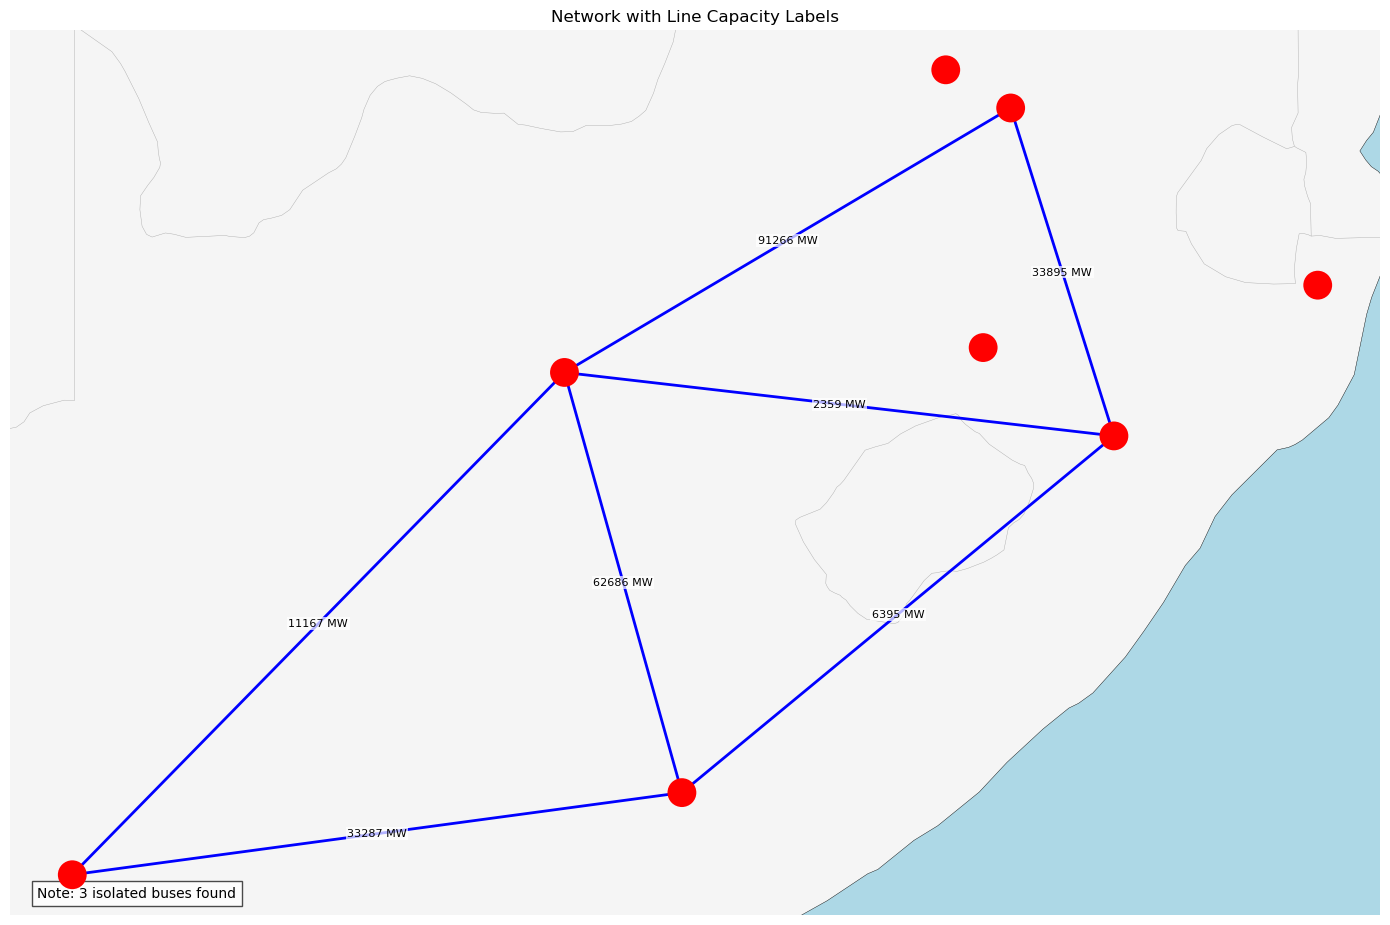

In [ ]:
# Visualize network with capacity labels instead of line thickness
fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={"projection": ccrs.PlateCarree()})

# Plot network with uniform line thickness
n.plot(
    ax=ax,
    bus_sizes=0.02,
    bus_colors='red',
    line_widths=2,  # Uniform line width
    line_colors='blue',
    title="Network with Line Capacity Labels",
    color_geomap=True,
    geomap=True,
)

# Add capacity labels to each line
if not n.lines.empty:
    # Format capacity values for display (in MW)
    for line in n.lines.index:
        bus0 = n.lines.at[line, 'bus0']
        bus1 = n.lines.at[line, 'bus1']
        
        # Get bus coordinates
        x0, y0 = n.buses.at[bus0, 'x'], n.buses.at[bus0, 'y']
        x1, y1 = n.buses.at[bus1, 'x'], n.buses.at[bus1, 'y']
        
        # Calculate midpoint for label placement
        mid_x = (x0 + x1) / 2
        mid_y = (y0 + y1) / 2
        
        # Format capacity value (rounded to nearest integer MW)
        capacity = int(round(n.lines.at[line, 's_nom']))
        
        # Add label with capacity value
        ax.text(mid_x, mid_y, f"{capacity} MW", 
                fontsize=8, 
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1),
                ha='center', va='center',
                zorder=5)  # Higher zorder to ensure labels are on top

# Add a note about disconnected buses
if 'isolated_buses' in locals() and len(isolated_buses) > 0:
    ax.text(0.02, 0.02, f"Note: {len(isolated_buses)} isolated buses found", 
            transform=ax.transAxes, fontsize=10, 
            bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()


In [12]:
print(n.lines)

      num_parallel  v_nom   bus0   bus1      length     dc  \
Line                                                         
0        19.602540  380.0  ZA0 0  ZA0 2  708.450417  False   
1         6.576316  380.0  ZA0 0  ZA0 3  895.762964  False   
2         3.765789  380.0  ZA0 1  ZA0 2  702.800210  False   
3         1.389474  380.0  ZA0 1  ZA0 3  664.223111  False   
4        19.960526  380.0  ZA0 1  ZA0 4  464.448620  False   
5        36.915606  380.0  ZA0 2  ZA0 3  589.505779  False   
6        53.745777  380.0  ZA0 3  ZA0 4  651.605614  False   

                                               geometry  \
Line                                                      
0     MULTILINESTRING ((20.01072339999996 -33.104816...   
1     MULTILINESTRING ((20.792915800000124 -29.49423...   
2     MULTILINESTRING ((28.3685 -31.0915, 28.3822105...   
3     MULTILINESTRING ((27.0844 -28.9435, 27.0852278...   
4     MULTILINESTRING ((29.7754 -27.0943, 29.7900769...   
5     MULTILINESTRING ((24.0

In [37]:
# Check the structure of loads in the network
print("Loads in the network:")
if not n.loads.empty:
    print(f"Number of loads: {len(n.loads)}")
    print("\nLoad columns:")
    print(n.loads.columns.tolist())
    print("\nFirst few loads:")
    print(n.loads.head())
    
    # Check if time-varying data is available
    if hasattr(n, 'loads_t') and hasattr(n.loads_t, 'p_set'):
        print("\nTime-varying load data available:")
        print(f"Time periods: {len(n.loads_t.p_set)}")
        print(f"Time index: {n.loads_t.p_set.index[:5]}...")
        print("\nSample of load time series data:")
        print(n.loads_t.p_set.iloc[:5, :3])  # First 5 time steps, first 3 loads
    else:
        print("\nNo time-varying load data found in n.loads_t.p_set")
else:
    print("No loads found in the network")


Loads in the network:
Number of loads: 8

Load columns:
['bus', 'carrier', 'type', 'p_set', 'q_set', 'sign']

First few loads:
         bus carrier type  p_set  q_set  sign
Load                                         
ZA0 0  ZA0 0                 0.0    0.0  -1.0
ZA0 1  ZA0 1                 0.0    0.0  -1.0
ZA0 2  ZA0 2                 0.0    0.0  -1.0
ZA0 3  ZA0 3                 0.0    0.0  -1.0
ZA0 4  ZA0 4                 0.0    0.0  -1.0

Time-varying load data available:
Time periods: 2920
Time index: DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 03:00:00',
               '2013-01-01 06:00:00', '2013-01-01 09:00:00',
               '2013-01-01 12:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq=None)...

Sample of load time series data:
Load                       ZA0 0        ZA0 1        ZA0 2
snapshot                                                  
2013-01-01 00:00:00  3202.097114  5828.719037  4393.962760
2013-01-01 03:00:00  3434.662460  6252.05350

Number of buses with loads: 8


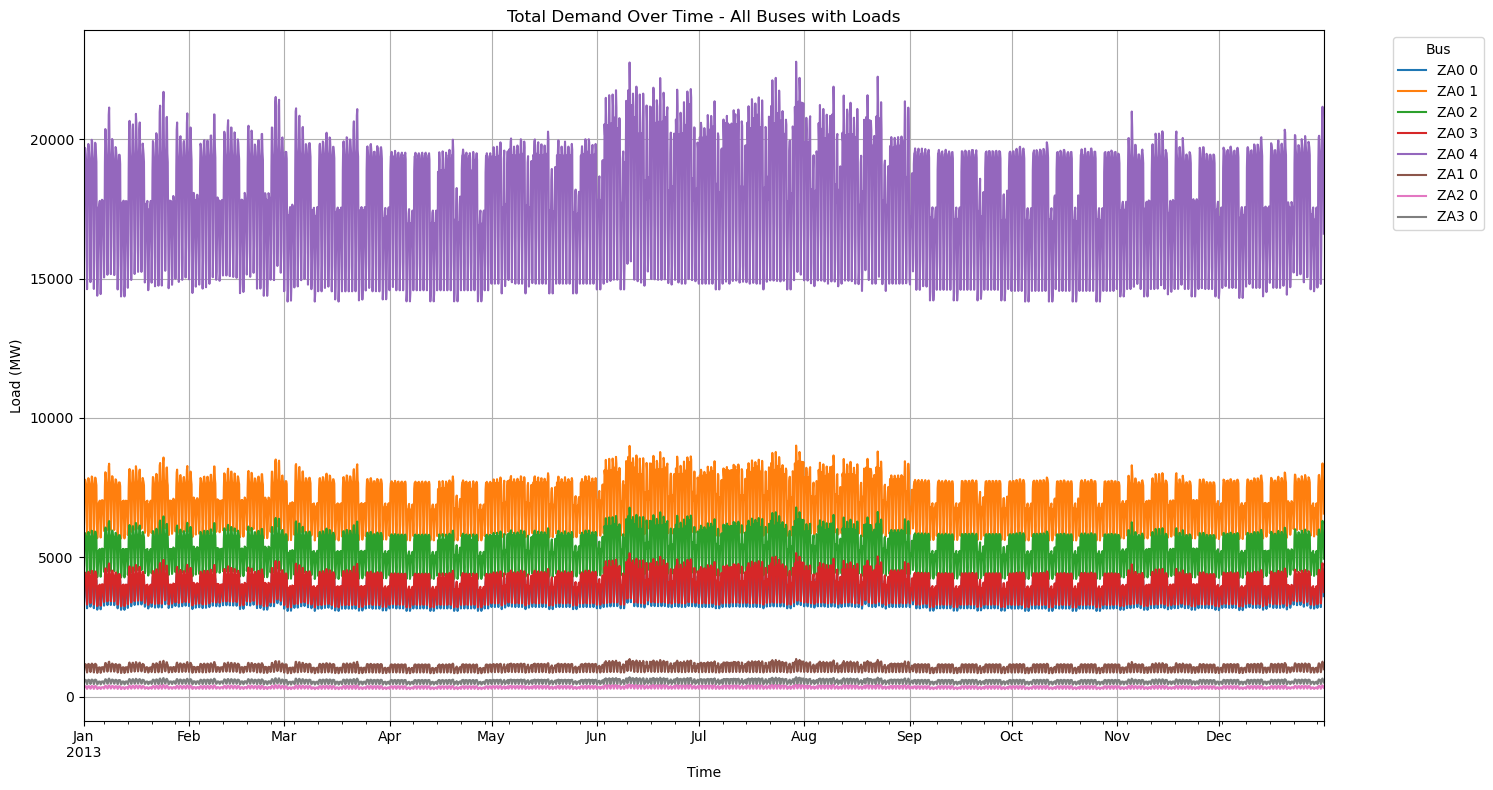


Summary statistics of bus demand:
        count          mean          std           min           25%  \
ZA0 4  2920.0  17843.942687  2022.082907  14174.492341  16208.324821   
ZA0 1  2920.0   7059.357178   799.969252   5607.662276   6412.279852   
ZA0 2  2920.0   5321.675715   603.054476   4227.319768   4833.878369   
ZA0 3  2920.0   4038.641155   457.660473   3208.130015   3668.449783   
ZA0 0  2920.0   3878.167245   439.475504   3080.656157   3522.685290   
ZA1 0  2920.0   1064.145751   120.589433    845.313508    966.603642   
ZA3 0  2920.0    553.322764    62.702763    439.536789    502.603894   
ZA2 0  2920.0    347.298847    39.356048    275.879885    315.464616   

                50%           75%           max  
ZA0 4  17826.623536  19545.387025  22775.505850  
ZA0 1   7052.505437   7732.476539   9010.364667  
ZA0 2   5316.510550   5829.104772   6792.436991  
ZA0 3   4034.721291   4423.731112   5154.807818  
ZA0 0   3874.403135   4247.955795   4949.983438  
ZA1 0   1063.112

In [40]:
# Customizable function for plotting bus demand over time
def plot_bus_demand_over_time(network, top_n=10, figsize=(15, 8), 
                             include_heatmap=False, heatmap_figsize=(16, 10)):
    """
    Plot the total demand (load) for each bus over time.
    
    Parameters:
    -----------
    network : pypsa.Network
        The PyPSA network to plot
    top_n : int, optional
        Number of top buses by average load to display in line plot (default: 10)
    figsize : tuple, optional
        Figure size for line plot (default: (15, 8))
    include_heatmap : bool, optional
        Whether to include a heatmap visualization (default: True)
    heatmap_figsize : tuple, optional
        Figure size for heatmap (default: (16, 10))
    """
    if not network.loads.empty and hasattr(network, 'loads_t') and hasattr(network.loads_t, 'p_set'):
        # Group loads by bus and sum them
        bus_loads = {}
        
        # Get unique buses with loads
        load_buses = network.loads.bus.unique()
        print(f"Number of buses with loads: {len(load_buses)}")
        
        # For each bus, sum up all loads connected to it at each time step
        for bus in load_buses:
            # Get indices of loads connected to this bus
            bus_load_indices = network.loads[network.loads.bus == bus].index
            
            # Sum up the load time series for this bus
            if len(bus_load_indices) > 0:
                bus_loads[bus] = network.loads_t.p_set[bus_load_indices].sum(axis=1)
        
        # Create a DataFrame with all bus loads
        bus_loads_df = pd.DataFrame(bus_loads)
        
        # 1. Line plot of load time series
        plt.figure(figsize=figsize)
        
        # If there are many buses, limit the number shown
        if len(bus_loads_df.columns) > top_n:
            # Plot top N buses by average load
            top_buses = bus_loads_df.mean().sort_values(ascending=False).head(top_n).index
            bus_loads_df[top_buses].plot(ax=plt.gca())
            plt.title(f'Total Demand Over Time - Top {top_n} Buses by Average Load')
        else:
            # Plot all buses if there aren't too many
            bus_loads_df.plot(ax=plt.gca())
            plt.title('Total Demand Over Time - All Buses with Loads')
        
        plt.xlabel('Time')
        plt.ylabel('Load (MW)')
        plt.grid(True)
        plt.legend(title='Bus', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
        # 2. Heatmap visualization (optional)
        if include_heatmap:
            plt.figure(figsize=heatmap_figsize)
            import seaborn as sns
            
            # If there are many time steps, sample them for better visualization
            if len(bus_loads_df) > 50:
                # Sample every Nth time step
                sample_step = len(bus_loads_df) // 50 + 1
                heatmap_data = bus_loads_df.iloc[::sample_step]
            else:
                heatmap_data = bus_loads_df
            
            # Create heatmap
            sns.heatmap(heatmap_data.T, cmap='viridis', 
                        xticklabels=20 if len(heatmap_data) > 20 else True,
                        yticklabels=True,
                        cbar_kws={'label': 'Load (MW)'})
            plt.title('Heatmap of Load Over Time for All Buses')
            plt.xlabel('Time Steps')
            plt.ylabel('Bus')
            plt.tight_layout()
            plt.show()
            
        # 3. Return the DataFrame for further analysis
        return bus_loads_df
    else:
        print("Cannot plot load time series: either no loads in the network or no time-varying data available")
        return None

# Example usage
bus_demand_df = plot_bus_demand_over_time(n, top_n=10)

# If you want to analyze the data further, you can use the returned DataFrame
if bus_demand_df is not None:
    # Print summary statistics
    print("\nSummary statistics of bus demand:")
    print(bus_demand_df.describe().T.sort_values('mean', ascending=False))


In [ ]:
# Examples of using the function with month selection
# Show winter months (June, July, August for Southern Hemisphere)
print("Winter months only (June, July, August):")
winter_demand = plot_bus_demand_over_time(n, months=[6, 7, 8], top_n=8)

# Show summer months (December, January, February for Southern Hemisphere)
print("\nSummer months only (December, January, February):")
summer_demand = plot_bus_demand_over_time(n, months=[12, 1, 2], top_n=8)

# Compare winter vs summer average demand
if winter_demand is not None and summer_demand is not None:
    winter_avg = winter_demand.mean()
    summer_avg = summer_demand.mean()
    
    print("\nAverage demand comparison (Winter vs Summer):")
    comparison = pd.DataFrame({
        'Winter Avg (MW)': winter_avg,
        'Summer Avg (MW)': summer_avg,
        'Difference (MW)': winter_avg - summer_avg,
        'Percentage Difference (%)': (winter_avg - summer_avg) / summer_avg * 100
    })
    print(comparison.sort_values('Winter Avg (MW)', ascending=False))


In [41]:
# Updated function with month selection capability
def plot_bus_demand_over_time_with_months(network, months=None, top_n=10, figsize=(15, 8), 
                                         include_heatmap=False, heatmap_figsize=(16, 10)):
    """
    Plot the total demand (load) for each bus over time with month selection.
    
    Parameters:
    -----------
    network : pypsa.Network
        The PyPSA network to plot
    months : list or None, optional
        List of months to include (1-12 for Jan-Dec). If None, include all months.
        Example: [1, 2, 3] for Jan, Feb, Mar only
    top_n : int, optional
        Number of top buses by average load to display in line plot (default: 10)
    figsize : tuple, optional
        Figure size for line plot (default: (15, 8))
    include_heatmap : bool, optional
        Whether to include a heatmap visualization (default: False)
    heatmap_figsize : tuple, optional
        Figure size for heatmap (default: (16, 10))
    """
    if not network.loads.empty and hasattr(network, 'loads_t') and hasattr(network.loads_t, 'p_set'):
        # Group loads by bus and sum them
        bus_loads = {}
        
        # Get unique buses with loads
        load_buses = network.loads.bus.unique()
        print(f"Number of buses with loads: {len(load_buses)}")
        
        # For each bus, sum up all loads connected to it at each time step
        for bus in load_buses:
            # Get indices of loads connected to this bus
            bus_load_indices = network.loads[network.loads.bus == bus].index
            
            # Sum up the load time series for this bus
            if len(bus_load_indices) > 0:
                bus_loads[bus] = network.loads_t.p_set[bus_load_indices].sum(axis=1)
        
        # Create a DataFrame with all bus loads
        bus_loads_df = pd.DataFrame(bus_loads)
        
        # Check if the time index has datetime information
        if pd.api.types.is_datetime64_any_dtype(bus_loads_df.index):
            # Filter by selected months if specified
            if months is not None:
                # Convert months to a list if it's a single integer
                if isinstance(months, int):
                    months = [months]
                
                # Filter the DataFrame to include only the selected months
                month_mask = bus_loads_df.index.month.isin(months)
                filtered_df = bus_loads_df.loc[month_mask]
                
                if filtered_df.empty:
                    print(f"Warning: No data found for the selected months {months}")
                    return None
                
                month_names = [pd.Timestamp(2023, m, 1).strftime('%B') for m in months]
                month_str = ", ".join(month_names)
                print(f"Showing data for months: {month_str}")
            else:
                filtered_df = bus_loads_df
                month_str = "all months"
        else:
            # If the index is not datetime, we can't filter by month
            filtered_df = bus_loads_df
            if months is not None:
                print("Warning: Time index is not datetime format, cannot filter by month")
            month_str = "all time periods"
        
        # 1. Line plot of load time series
        plt.figure(figsize=figsize)
        
        # If there are many buses, limit the number shown
        if len(filtered_df.columns) > top_n:
            # Plot top N buses by average load
            top_buses = filtered_df.mean().sort_values(ascending=False).head(top_n).index
            filtered_df[top_buses].plot(ax=plt.gca())
            plt.title(f'Total Demand Over Time - Top {top_n} Buses by Average Load ({month_str})')
        else:
            # Plot all buses if there aren't too many
            filtered_df.plot(ax=plt.gca())
            plt.title(f'Total Demand Over Time - All Buses with Loads ({month_str})')
        
        plt.xlabel('Time')
        plt.ylabel('Load (MW)')
        plt.grid(True)
        plt.legend(title='Bus', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
        # 2. Heatmap visualization (optional)
        if include_heatmap:
            plt.figure(figsize=heatmap_figsize)
            import seaborn as sns
            
            # If there are many time steps, sample them for better visualization
            if len(filtered_df) > 50:
                # Sample every Nth time step
                sample_step = len(filtered_df) // 50 + 1
                heatmap_data = filtered_df.iloc[::sample_step]
            else:
                heatmap_data = filtered_df
            
            # Create heatmap
            sns.heatmap(heatmap_data.T, cmap='viridis', 
                        xticklabels=20 if len(heatmap_data) > 20 else True,
                        yticklabels=True,
                        cbar_kws={'label': 'Load (MW)'})
            plt.title(f'Heatmap of Load Over Time for All Buses ({month_str})')
            plt.xlabel('Time Steps')
            plt.ylabel('Bus')
            plt.tight_layout()
            plt.show()
            
        # 3. Return the filtered DataFrame for further analysis
        return filtered_df
    else:
        print("Cannot plot load time series: either no loads in the network or no time-varying data available")
        return None


Number of buses with loads: 8
Showing data for months: January


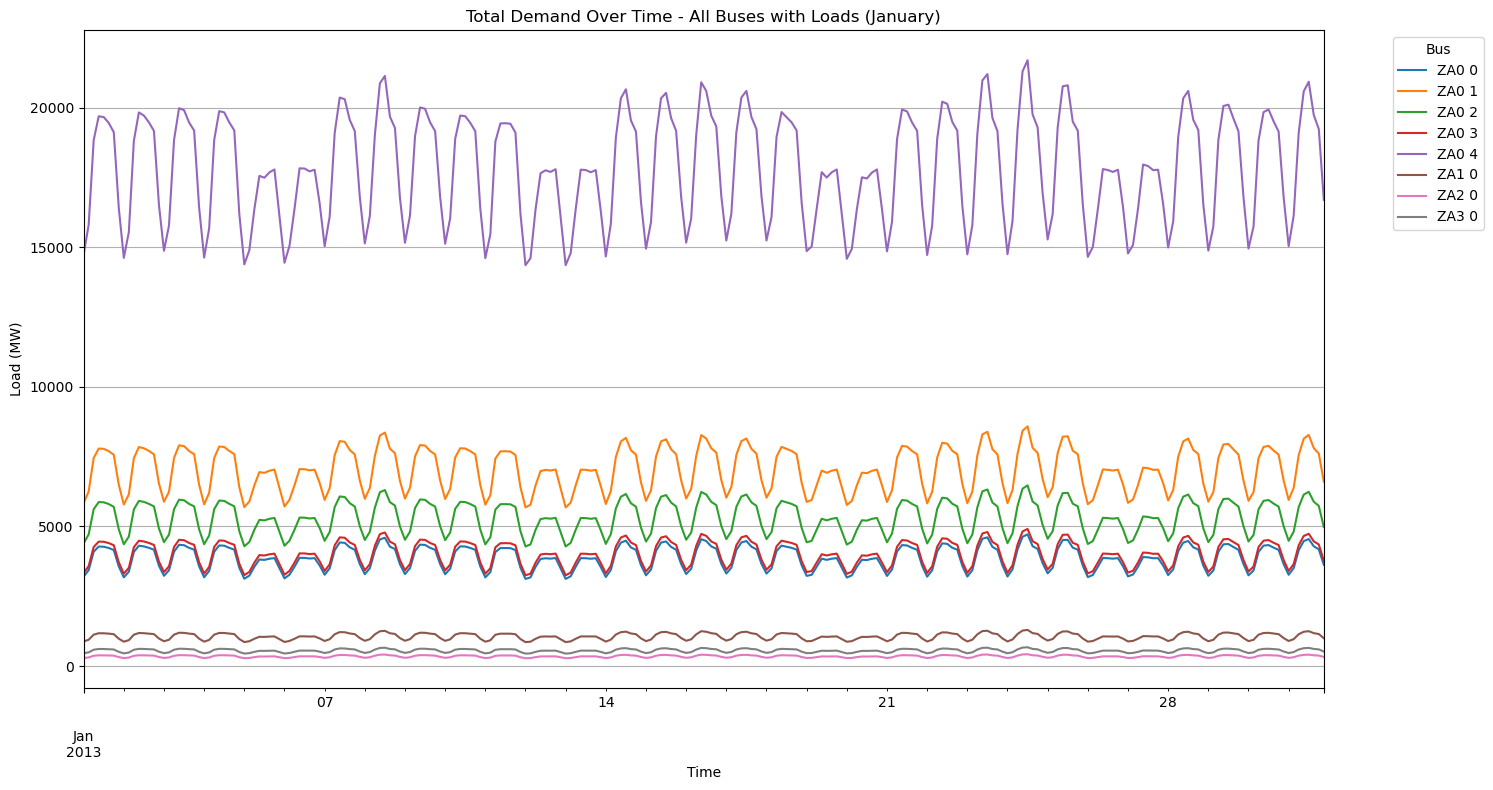

,ZA0 0,ZA0 1,ZA0 2,ZA0 3,ZA0 4,ZA1 0,ZA2 0,ZA3 0
snapshot,,,,,,,,
2013-01-01 00:00:00,3202.097114,5828.719037,4393.962760,3334.596053,14733.257691,878.636176,286.755203,456.863542
2013-01-01 03:00:00,3434.662460,6252.053500,4713.092203,3576.784675,15803.320544,942.450707,307.581968,490.045118
2013-01-01 06:00:00,4094.000672,7452.234833,5617.845383,4263.405511,18837.019844,1123.369144,366.627230,584.117090
2013-01-01 09:00:00,4278.923746,7788.846936,5871.599430,4455.980480,19687.874521,1174.110923,383.187519,610.501240
2013-01-01 12:00:00,4272.862344,7777.813477,5863.281889,4449.668264,19659.985237,1172.447711,382.644706,609.636422
...,...,...,...,...,...,...,...,...
2013-01-31 09:00:00,4473.099677,8142.301846,6138.050378,4658.191179,20581.302775,1227.391630,400.576423,638.205554
2013-01-31 12:00:00,4547.415911,8277.578333,6240.028161,4735.582529,20923.241256,1247.783557,407.231613,648.808724
2013-01-31 15:00:00,4288.713844,7806.667673,5885.033541,4466.175681,19732.920012,1176.797267,384.064245,611.898056


In [42]:
plot_bus_demand_over_time_with_months(network=n, months=[1])